In [1]:
import os
import sys
import dill as pickle
from pathlib import Path
from itertools import product
from functools import partial

import do_mpc
import numpy as np
import casadi as ca
import pandas as pd
import matplotlib.pyplot as plt
import pysindy as ps

from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
%matplotlib inline

In [3]:
results_dir = Path("/scratch/kmaroun/sindy_freq_amp").resolve()

In [4]:
results_dir

PosixPath('/scratch/kmaroun/sindy_freq_amp')

In [5]:
def load_df(freq, amp):
    df = pd.read_hdf(results_dir / f"simu_f_{freq}_a_{amp}/obstacles.hdf5")
    return df

In [6]:
def load_ed(freq, amp):
    with open(results_dir / f"simu_f_{freq}_a_{amp}/ed.pkl", "rb") as f:
        ed = pickle.load(f)
    return ed

In [7]:
freqs = [1.0, 1.5, 2.0, 2.5, 3.0]
amps = [0.5, 1.0, 1.5]

In [8]:
df_list = []
ed_list = []

for f, a in product(freqs, amps):
    df_list.append(load_df(f, a))
    ed_list.append(load_ed(f,a))

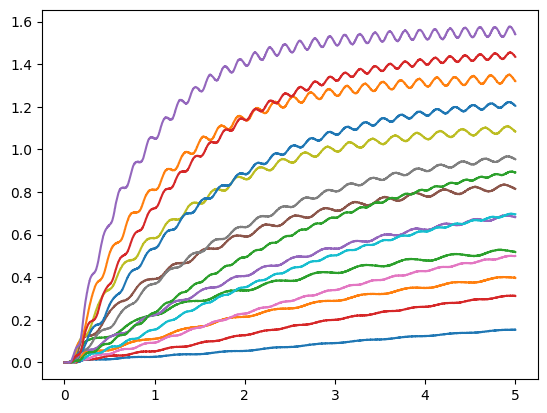

In [9]:
for df in df_list:
    plt.plot(df["time"], df["Ux"].abs())

In [10]:
df_list[0].head()

,time,frequency,amplitude,x,y,Ux,Uy,Fx,Fy,Pd,surface_area
0,0.000,1.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.108526
1,0.002,1.0,0.000149,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.108578
2,0.004,1.0,0.000592,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.108578
3,0.006,1.0,0.001323,0.000002,0.0,0.000751,-2.580422e-07,0.040773,-0.000014,0.000847,0.108578
4,0.008,1.0,0.002336,0.000003,0.0,0.000589,4.846874e-05,-0.008796,0.002645,0.002105,0.108578


In [32]:
time = list(map(lambda df: df["time"].to_numpy(), df_list))
Ux = list(map(lambda df: df["Ux"].to_numpy().reshape(-1, 1), df_list))
controls = list(map(lambda df: np.concatenate((df["frequency"].to_numpy().reshape(-1, 1),
                                              df["amplitude"].to_numpy().reshape(-1, 1)), axis=1), df_list))

In [33]:
Ux_array = np.asarray(Ux).squeeze().flatten()

In [42]:
def train_ux(train_trajectories, train_controls, train_times, threshold, degree=5, custom_lib=True):
    feature_names = ["ux", "f", "a"]
    
    if not custom_lib:
        sindy_lib = ps.PolynomialLibrary(degree=degree, include_interaction=True, include_bias=False)
    
    else:
        poly_lib_ux = ps.PolynomialLibrary(degree=degree, include_bias=False)
    
        af_functions = [
            lambda x,y: x*y,
            lambda x,y: x**2*y,
            lambda x,y: x*y**2,
            lambda x,y: x**2*y**2,
            lambda x,y: x**3*y,
            lambda x,y: x*y**3, 
        ]

        af_functions_names = [
            lambda x,y: x+' '+y,
            lambda x,y: x+'^2 '+y,
            lambda x,y: x+' '+y+'^2',
            lambda x,y: x+'^2 '+y+'^2',
            lambda x,y: x+'^3 '+y,
            lambda x,y: x+' '+y+'^3',  
        ]

        af_lib = ps.CustomLibrary(library_functions=af_functions, function_names=af_functions_names)

        uaf_functions = [
            lambda x,y,z: x*y*z,
            lambda x,y,z: x**2*y*z,
            lambda x,y,z: x*y**2*z,
            lambda x,y,z: x*y*z**2,
        ]

        uaf_functions_names = [
            lambda x,y,z: x+' '+y+' '+z,
            lambda x,y,z: x+'^2 '+y+' '+z,
            lambda x,y,z: x+' '+y+'^2 '+z,
            lambda x,y,z: x+' '+y+' '+z+'^2',
        ]

        uaf_lib = ps.CustomLibrary(library_functions=uaf_functions, function_names=uaf_functions_names)

        inputs_per_library = np.tile([0,1,2], 3).reshape((3,3))
        inputs_per_library[0,1]=0
        inputs_per_library[0,2]=0
        inputs_per_library[1,0]=1

        print(inputs_per_library)
    
        sindy_lib = ps.GeneralizedLibrary([poly_lib_ux, af_lib, uaf_lib], inputs_per_library=inputs_per_library)
    
    alpha = 2.0
    #sfd = ps.SINDyDerivative(kind="kalman", alpha=alpha)
    sfd = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 10})
        
    
    opt = ps.STLSQ(threshold=threshold)
    
    model = ps.SINDy(optimizer=opt, differentiation_method=sfd, feature_library=sindy_lib,
                 feature_names=feature_names)
    
    model.fit(train_trajectories, t=train_times, u=train_controls, multiple_trajectories=True)
    
    return model

In [49]:
threshold = 0.02
model = train_ux(train_trajectories=Ux, train_controls=controls, 
                 train_times=time, threshold=threshold, degree=3, custom_lib=True)

[[0 0 0]
 [1 1 2]
 [0 1 2]]


In [50]:
model.print()

(ux)' = -0.180 ux + -0.137 ux^2 + -0.391 ux^3 + -0.033 f a + 0.011 f^2 a + -0.036 f a^2 + -0.094 f^2 a^2 + -0.012 f^3 a + 0.007 f a^3 + 0.244 ux f a + -0.279 ux^2 f a + -0.108 ux f^2 a + -0.344 ux f a^2


In [51]:
print(len(model.get_feature_names()))
print(len(model.coefficients().nonzero()[1]))

13
13


In [52]:
#with open("sindy_model.pkl", "wb") as f:
#    pickle.dump(model, f)

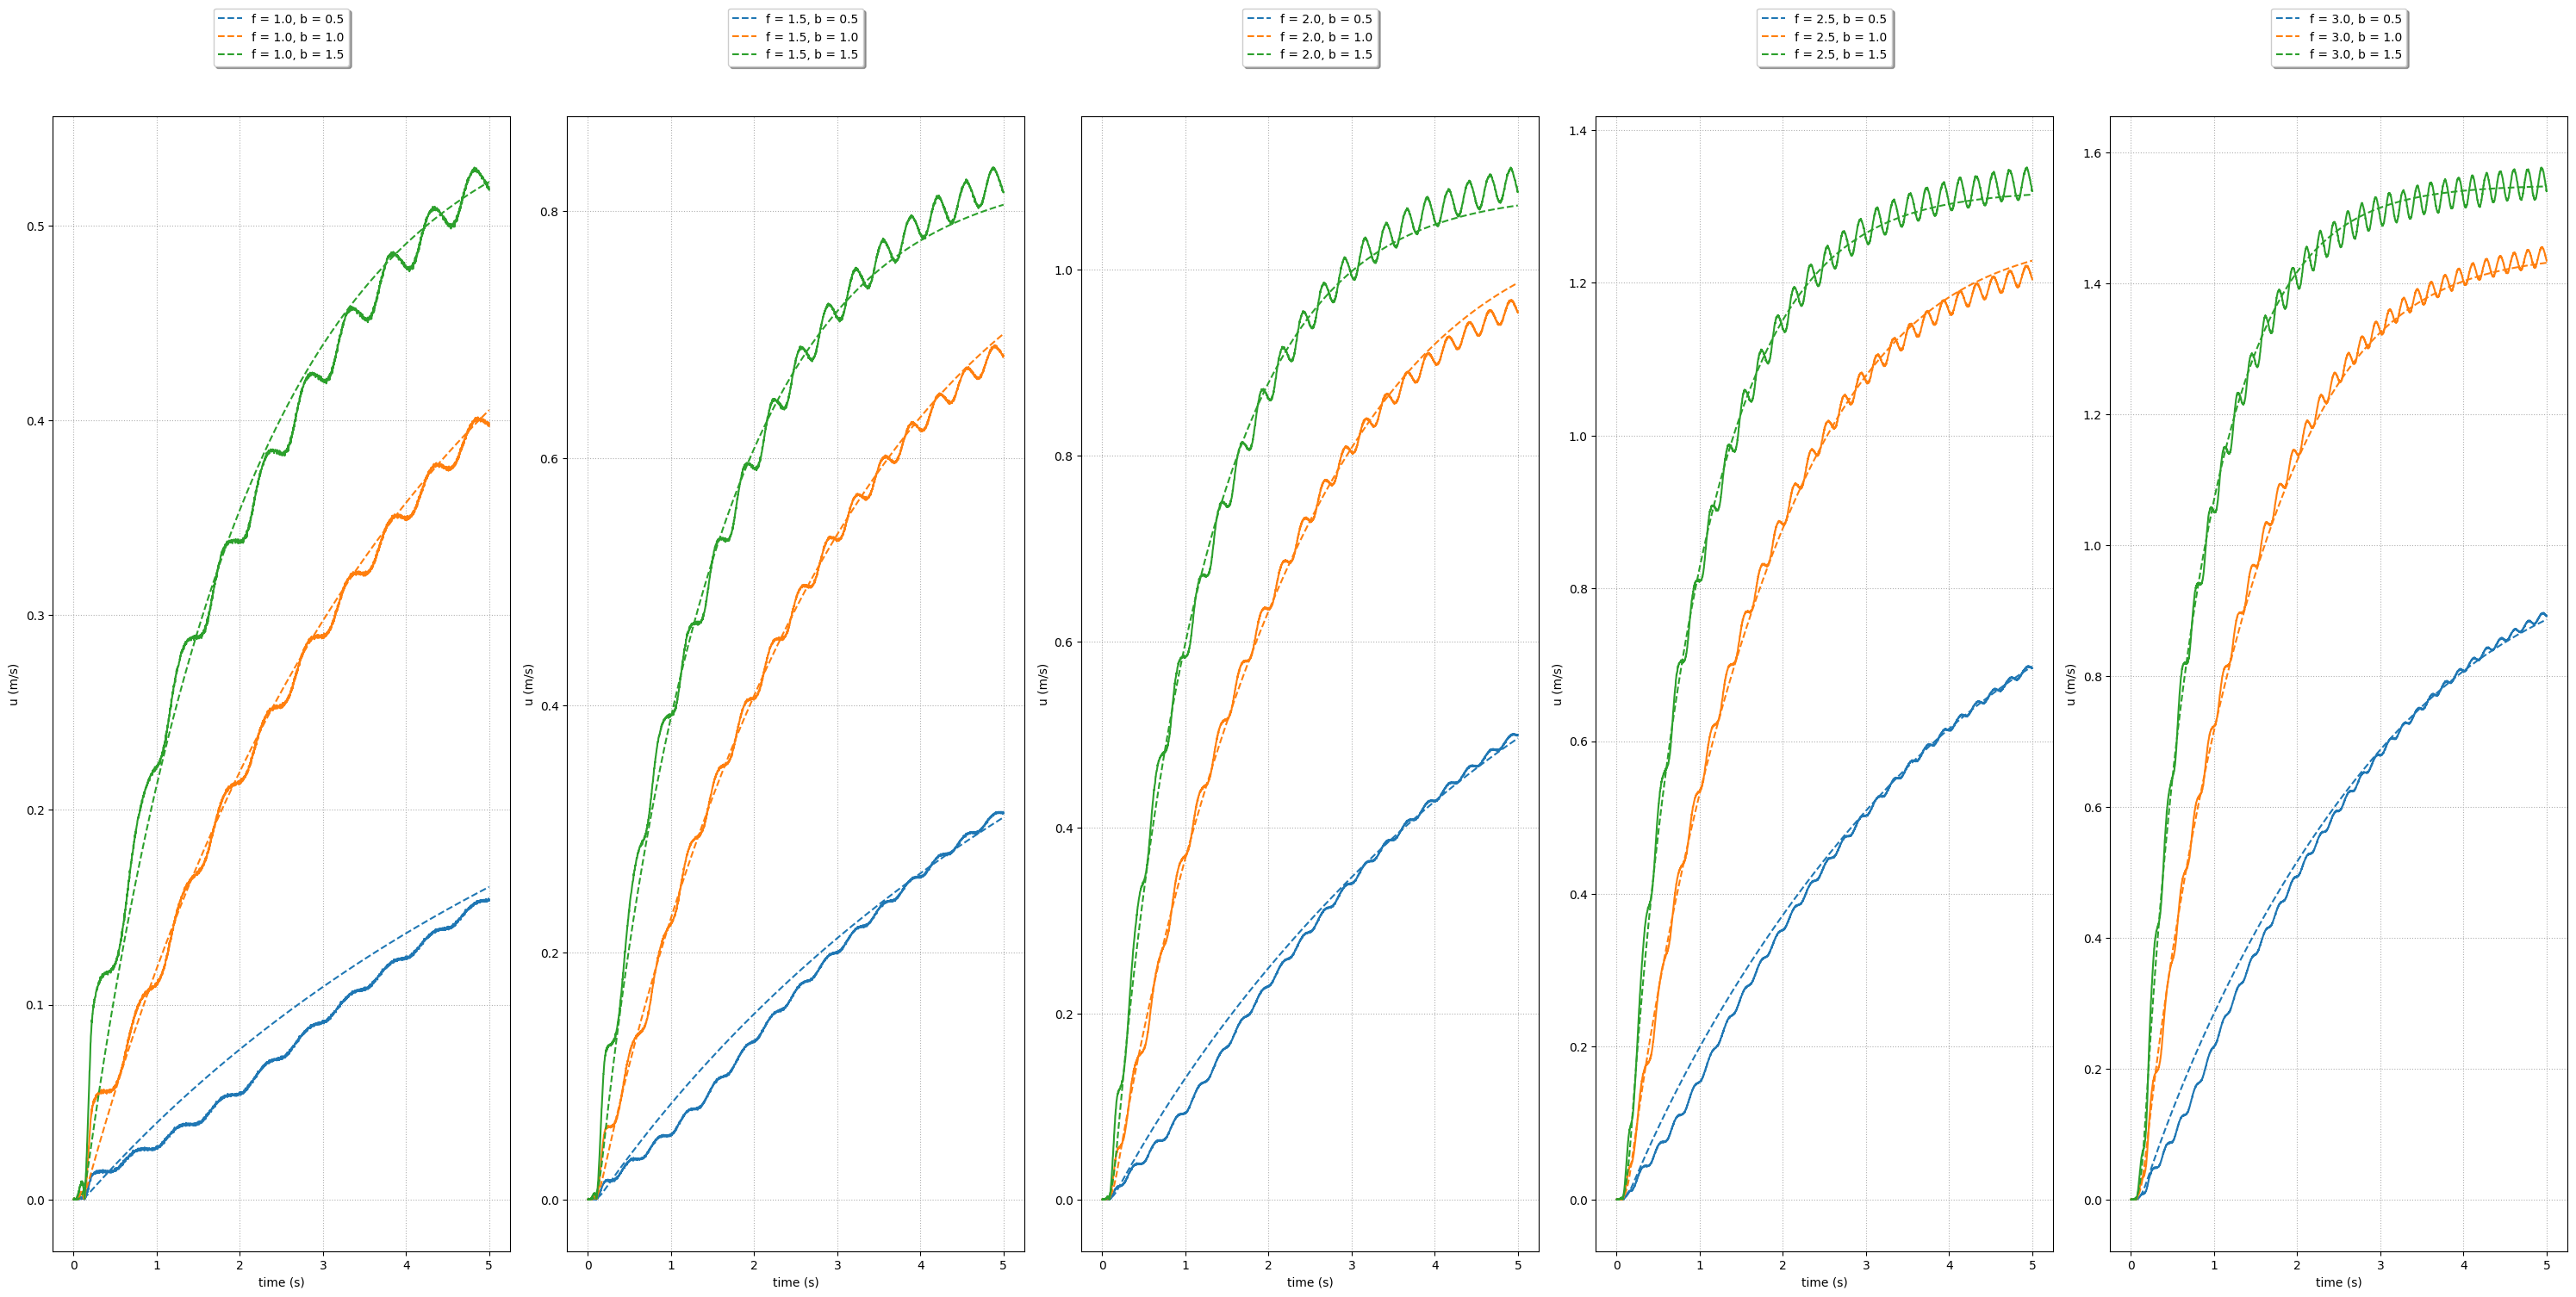

In [53]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize=(30, 15))
counter = 0
n = 15
for i, (t, c, u) in enumerate(zip(time[:n], controls[:n], Ux[:n])):
    x0_test = [0.0]
    f, a = c[1000]
    if i != 0 and i % 3 == 0:
        counter += 1
    x_test = model.simulate(x0=x0_test, t=t, u=c)
    line, = axes[counter].plot(t[1:], np.abs(x_test), label=f"f = {f}, b = {a}", linestyle="--")
    axes[counter].plot(t, np.abs(u), line.get_color())
    axes[counter].grid(True, linestyle="dotted")
    axes[counter].set_xlabel("time (s)")
    axes[counter].set_ylabel("u (m/s)")
    handles, labels = axes[counter].get_legend_handles_labels()
    axes[counter].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)

#handles, labels = axes[counter].get_legend_handles_labels()    
fig.tight_layout()
#fig.savefig("sindy_fit.png", bbox_inches='tight')
#fig.legend(handles, labels, bbox_to_anchor=(0.8, 1.05), ncol=2)

In [18]:
model_type = "continuous"
mpc_model = do_mpc.model.Model(model_type)

ux = mpc_model.set_variable(var_type="_x", var_name="ux", shape=(1,1))
f = mpc_model.set_variable(var_type="_u", var_name="f")
a = mpc_model.set_variable(var_type="_u", var_name="a")

In [19]:
class Sindy2MPC:
    def __init__(self, sindy_model, mpc_model):
        self._sindy_model = sindy_model
        self._mpc_model = mpc_model
        self._feature_names = self._sindy_model.feature_names
        self._check_feature_names()
        
        self._basis_functions = self._sindy_model.get_feature_names()
        self._coefficients = self._sindy_model.coefficients()
        
        self._n_odes, self._n_basis_functions = self._coefficients.shape

        assert self._n_odes == len(self._mpc_model.x.keys())
        
        self._processed_ftr_list = [[]]*self._n_odes
        
        self._get_processed_ftr_list()
    
    def _check_feature_names(self):
        for feature in self._feature_names:
            assert (feature in self._mpc_model.x.keys()) or (feature in self._mpc_model.u.keys())
            
    def _access_mpc_model_var(self, var_name):
        if var_name in self._mpc_model.x.keys():
            return self._mpc_model.x[var_name]
        elif var_name in self._mpc_model.u.keys():
            return self._mpc_model.u[var_name]  
    
    def _process_ftr(self, split_ftr):
        if '^' in split_ftr:
            var_name, exp = split_ftr.split('^')
            mpc_var = self._access_mpc_model_var(var_name)
            return mpc_var**(int(exp))
        else:
            mpc_var = self._access_mpc_model_var(split_ftr)
            return mpc_var
    
    def _get_processed_ftr_list(self):
        for ode_idx,coef_array in enumerate(self._sindy_model.coefficients()): 
            for ftr, coef in zip(self._sindy_model.get_feature_names(), coef_array):
                if coef != 0:
                    self._processed_ftr_list[ode_idx].append(np.prod(list(map(self._process_ftr, ftr.split()))))
    
    def set_mpc_model_rhs(self):
        for n, x in enumerate(self._mpc_model.x.keys()):
            print(n, x)
            coefs = self._coefficients[n]
            nnz_idx = coefs.nonzero()
            nnz_coefs = coefs[nnz_idx]
            rhs = 0
            for ftr, coef in zip(self._processed_ftr_list[n], nnz_coefs):
                rhs += ftr*coef
            self._mpc_model.set_rhs(x, rhs)

In [20]:
sindy2mpc = Sindy2MPC(sindy_model=model, mpc_model=mpc_model)

In [21]:
sindy2mpc.set_mpc_model_rhs()

mpc_model.setup()

0 ux


In [22]:
simulator = do_mpc.simulator.Simulator(mpc_model)
simulator.set_param(t_step = 0.002)
simulator.setup()

In [23]:
N = 2500
#control = np.ones(2, dtype=np.float32).reshape((2, 1))
dt = 0.002

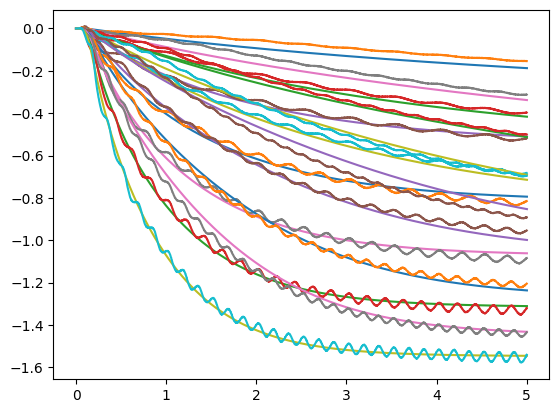

In [24]:
for t, c, u in zip(time, controls, Ux):
    #control = np.array([f, a], dtype=np.float32).reshape((2,1))
    simulator.x0["ux"] = 0.0
    traj = []
    time_sim = []
    tsim = 0
    for ci in c:
        ci = ci.reshape((2,1))
        x = simulator.make_step(ci)
        traj.append(x.item())
        tsim += dt
        time_sim.append(tsim)
    plt.plot(time_sim, traj)
    plt.plot(t, u)

In [25]:
mpc_controller = do_mpc.controller.MPC(mpc_model)

In [26]:
setup_mpc = {
    'n_horizon': 50,
    't_step': 0.01,
    'store_full_solution': True,
}

In [27]:
mpc_controller.set_param(**setup_mpc)

In [28]:
u_target = -1.0
mterm = (ux-u_target)**2
lterm = (ux-u_target)**2

mpc_controller.set_objective(mterm=mterm, lterm=lterm)
mpc_controller.set_rterm(f=1.0, a=1.0)

In [29]:
mpc_controller.bounds["lower", "_u", "f"] = 0
mpc_controller.bounds["upper", "_u", "f"] = 3
mpc_controller.bounds["lower", "_u", "a"] = 0
mpc_controller.bounds["upper", "_u", "a"] = 1.5

In [30]:
mpc_controller.setup()

In [31]:
simulator.x0["ux"] = 0.0
mpc_controller.x0["ux"] = 0.0
mpc_controller.set_initial_guess()

In [32]:
opt_traj = []
opt_controls = []
t_opt = 0
time_opt = []

N = 500
x0 = np.array([0.0]).reshape(-1,1)

for i in range(N):
    u0 = mpc_controller.make_step(x0)
    for _ in range(5):
        x0 = simulator.make_step(u0)
        opt_traj.append(x0)
        opt_controls.append(u0)
        t_opt += 0.002
        time_opt.append(t_opt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      701
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      599

Total number of variables............................:      304
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:      201
Total number of inequality c

   8  2.1364087e+01 2.80e-07 9.17e-08  -5.7 4.65e-03  -7.3 1.00e+00 1.00e+00f  1
   9  2.1363911e+01 4.11e-08 9.89e-05  -8.6 1.32e-03  -7.8 1.00e+00 9.22e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1363895e+01 3.81e-09 3.33e-05  -8.6 3.75e-04  -8.3 1.00e+00 9.46e-01f  1
  11  2.1363893e+01 4.38e-11 1.50e-11  -8.6 6.42e-05  -8.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   2.1363893433851921e+01    2.1363893433851921e+01
Dual infeasibility......:   1.4993228880655352e-11    1.4993228880655352e-11
Constraint violation....:   4.3800242946478996e-11    4.3800242946478996e-11
Variable bound violation:   2.5136375647605291e-08    2.5136375647605291e-08
Complementarity.........:   8.6174335039383950e-09    8.6174335039383950e-09
Overall NLP error.......:   8.6174335039383950e-09    8.6174335039383950e-09


Number of objective function 

   7  1.5013746e+01 3.89e-08 8.04e-05  -8.6 1.33e-03  -6.9 1.00e+00 9.22e-01h  1
   8  1.5013730e+01 3.84e-09 3.19e-05  -8.6 3.82e-04  -7.3 1.00e+00 9.44e-01f  1
   9  1.5013728e+01 6.34e-11 1.88e-11  -8.6 7.41e-05  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5013728e+01 8.04e-14 2.75e-14  -9.0 3.11e-06  -8.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.5013728309311441e+01    1.5013728309311441e+01
Dual infeasibility......:   2.7464142071664810e-14    2.7464142071664810e-14
Constraint violation....:   8.0364534471577542e-14    8.0364534471577542e-14
Variable bound violation:   2.8202469692928389e-08    2.8202469692928389e-08
Complementarity.........:   9.2685116292041591e-10    9.2685116292041591e-10
Overall NLP error.......:   9.2685116292041591e-10    9.2685116292041591e-10


Number of objective function 

   5  1.1366871e+01 4.58e-06 5.97e-05  -5.7 2.13e-02  -5.9 9.98e-01 9.69e-01h  1
   6  1.1366168e+01 3.38e-07 7.32e-08  -5.7 5.25e-03  -6.4 1.00e+00 1.00e+00f  1
   7  1.1365981e+01 5.03e-08 6.05e-05  -8.6 1.61e-03  -6.9 1.00e+00 9.33e-01h  1
   8  1.1365966e+01 4.93e-09 2.69e-05  -8.6 4.70e-04  -7.3 1.00e+00 9.52e-01f  1
   9  1.1365965e+01 1.36e-10 3.34e-11  -8.6 1.05e-04  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1365965e+01 7.44e-13 1.63e-13  -9.0 8.37e-06  -8.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.1365964630548183e+01    1.1365964630548183e+01
Dual infeasibility......:   1.6298074001497298e-13    1.6298074001497298e-13
Constraint violation....:   7.4391708071441798e-13    7.4391708071441798e-13
Variable bound violation:   2.7807786295852566e-08    2.7807786295852566e-08
Complementarity........

   8  8.4944575e+00 1.06e-08 3.95e-05  -8.6 6.55e-04  -7.3 1.00e+00 9.24e-01f  1
   9  8.4944556e+00 8.13e-10 1.19e-05  -8.6 1.77e-04  -7.8 1.00e+00 9.58e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.4944554e+00 1.23e-11 2.22e-12  -8.6 3.13e-05  -8.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   8.4944554445749976e+00    8.4944554445749976e+00
Dual infeasibility......:   2.2203072713722349e-12    2.2203072713722349e-12
Constraint violation....:   1.2282177011546658e-11    1.2282177011546658e-11
Variable bound violation:   2.2587752113167880e-08    2.2587752113167880e-08
Complementarity.........:   4.1440094533241811e-09    4.1440094533241811e-09
Overall NLP error.......:   4.1440094533241811e-09    4.1440094533241811e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations            

   7  6.2434022e+00 1.33e-07 5.54e-05  -8.6 2.80e-03  -6.9 9.99e-01 9.08e-01h  1
   8  6.2433804e+00 1.98e-08 3.65e-05  -8.6 9.72e-04  -7.3 1.00e+00 9.17e-01h  1
   9  6.2433779e+00 1.52e-09 8.59e-06  -8.6 2.95e-04  -7.8 1.00e+00 9.69e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.2433777e+00 4.99e-11 5.14e-12  -8.6 6.68e-05  -8.3 1.00e+00 1.00e+00f  1
  11  6.2433776e+00 1.00e-12 9.29e-14  -9.0 9.87e-06  -8.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   6.2433775533027811e+00    6.2433775533027811e+00
Dual infeasibility......:   9.2897911585509974e-14    9.2897911585509974e-14
Constraint violation....:   1.0016276003055324e-12    1.0016276003055324e-12
Variable bound violation:   2.6670308628240491e-08    2.6670308628240491e-08
Complementarity.........:   1.0917972495087565e-09    1.0917972495087565e-09
Overall NLP error.......:  

   1  5.6543587e+00 2.06e-04 1.91e-02  -1.0 9.80e-02  -4.0 1.00e+00 1.00e+00f  1
   2  5.0699472e+00 9.93e-05 5.43e-03  -2.5 7.99e-02  -4.5 9.64e-01 1.00e+00f  1
   3  4.5897388e+00 3.36e-05 3.63e-03  -3.8 7.96e-02  -5.0 9.73e-01 1.00e+00f  1
   4  4.5145247e+00 1.20e-05 1.46e-04  -3.8 4.68e-02  -5.4 1.00e+00 1.00e+00f  1
   5  4.4959142e+00 1.08e-05 1.04e-04  -5.7 3.89e-02  -5.9 9.86e-01 1.00e+00h  1
   6  4.4950576e+00 1.38e-06 1.12e-06  -5.7 1.27e-02  -6.4 1.00e+00 1.00e+00h  1
   7  4.4948457e+00 2.96e-07 5.55e-05  -8.6 4.61e-03  -6.9 9.98e-01 9.04e-01h  1
   8  4.4948182e+00 5.51e-08 4.13e-05  -8.6 1.78e-03  -7.3 1.00e+00 8.98e-01h  1
   9  4.4948142e+00 8.50e-09 2.10e-05  -8.6 6.34e-04  -7.8 1.00e+00 9.06e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4948136e+00 8.04e-10 6.68e-06  -8.6 2.11e-04  -8.3 1.00e+00 9.54e-01f  1
  11  4.4948135e+00 3.19e-11 2.66e-13  -8.6 5.64e-05  -8.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   6  3.3960066e+00 2.73e-06 5.43e-06  -5.7 1.90e-02  -6.4 1.00e+00 1.00e+00h  1
   7  3.3957556e+00 7.93e-07 7.77e-05  -8.6 8.40e-03  -6.9 9.96e-01 8.80e-01h  1
   8  3.3957115e+00 2.28e-07 8.48e-05  -8.6 4.07e-03  -7.3 1.00e+00 8.46e-01h  1
   9  3.3957022e+00 6.26e-08 7.32e-05  -8.6 1.95e-03  -7.8 1.00e+00 8.33e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.3957000e+00 1.46e-08 4.02e-05  -8.6 9.32e-04  -8.3 1.00e+00 8.68e-01f  1
  11  3.3956995e+00 2.32e-09 1.15e-05  -8.6 4.18e-04  -8.8 1.00e+00 9.47e-01f  1
  12  3.3956994e+00 2.66e-10 5.60e-11  -8.6 1.63e-04  -9.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   3.3956994443016923e+00    3.3956994443016923e+00
Dual infeasibility......:   5.6010248522531114e-11    5.6010248522531114e-11
Constraint violation....:   2.6605424981174242e-10    2.6605424981174242e-10
Variable bound viol

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5214758e+00 5.84e-09 2.23e-05  -8.6 7.47e-04  -8.3 1.00e+00 9.65e-01f  1
  11  2.5214757e+00 1.66e-10 5.15e-10  -8.6 1.24e-04  -8.8 1.00e+00 1.00e+00f  1
  12  2.5214756e+00 1.09e-11 2.99e-11  -9.0 4.37e-05  -9.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   2.5214755904541297e+00    2.5214755904541297e+00
Dual infeasibility......:   2.9945717238376302e-11    2.9945717238376302e-11
Constraint violation....:   1.0943412842578937e-11    1.0943412842578937e-11
Variable bound violation:   2.3684230576748178e-08    2.3684230576748178e-08
Complementarity.........:   4.7728071026485997e-09    4.7728071026485997e-09
Overall NLP error.......:   4.7728071026485997e-09    4.7728071026485997e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations            

   1  2.1714414e+00 1.76e-04 8.40e-03  -1.0 9.78e-02  -4.0 1.00e+00 1.00e+00f  1
   2  1.9918542e+00 4.86e-05 2.85e-03  -2.5 6.14e-02  -4.5 9.76e-01 1.00e+00f  1
   3  1.7538608e+00 5.43e-05 2.62e-03  -3.8 7.80e-02  -5.0 9.80e-01 1.00e+00f  1
   4  1.7062460e+00 7.26e-06 2.06e-04  -3.8 3.25e-02  -5.4 1.00e+00 1.00e+00h  1
   5  1.6930644e+00 5.25e-06 9.33e-05  -5.7 3.51e-02  -5.9 9.86e-01 9.85e-01h  1
   6  1.6917513e+00 1.14e-06 1.22e-05  -5.7 1.38e-02  -6.4 1.00e+00 1.00e+00h  1
   7  1.6916015e+00 2.91e-07 1.97e-04  -8.6 4.92e-03  -6.9 9.96e-01 8.63e-01h  1
   8  1.6915793e+00 7.15e-08 2.66e-04  -8.6 1.97e-03  -7.3 1.00e+00 8.30e-01h  1
   9  1.6915751e+00 1.01e-08 8.98e-05  -8.6 6.51e-04  -7.8 1.00e+00 9.11e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6915747e+00 3.04e-10 1.23e-09  -8.6 2.37e-04  -8.3 1.00e+00 1.00e+00f  1
  11  1.6915746e+00 2.07e-11 1.18e-10  -8.6 9.22e-05  -8.8 1.00e+00 1.00e+00h  1
  12  1.6915745e+00 3.45e-12

   7  1.1975611e+00 9.96e-08 6.09e-07  -5.7 3.47e-03  -6.9 1.00e+00 1.00e+00f  1
   8  1.1974853e+00 2.92e-08 2.26e-04  -8.6 1.55e-03  -7.3 9.99e-01 8.54e-01h  1
   9  1.1974723e+00 2.92e-09 1.58e-08  -8.6 5.36e-04  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1974722e+00 5.26e-11 2.38e-10  -8.6 1.13e-04  -8.3 1.00e+00 1.00e+00h  1
  11  1.1974722e+00 7.69e-13 2.23e-12  -8.6 1.28e-05  -8.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.1974722024040552e+00    1.1974722024040552e+00
Dual infeasibility......:   2.2344378951266730e-12    2.2344378951266730e-12
Constraint violation....:   7.6876959659299970e-13    7.6876959659299970e-13
Variable bound violation:   1.3915224528204817e-10    1.3915224528204817e-10
Complementarity.........:   2.8544134390007508e-09    2.8544134390007508e-09
Overall NLP error.......:  

   1  9.7303538e-01 1.57e-04 4.97e-03  -1.0 9.78e-02  -4.0 1.00e+00 1.00e+00f  1
   2  9.0569026e-01 3.15e-05 2.06e-03  -2.5 5.23e-02  -4.5 9.82e-01 1.00e+00h  1
   3  7.8627826e-01 6.78e-05 2.03e-03  -3.8 8.07e-02  -5.0 9.83e-01 1.00e+00f  1
   4  7.5695785e-01 6.48e-06 1.93e-04  -3.8 2.89e-02  -5.4 1.00e+00 1.00e+00h  1
   5  7.4821864e-01 4.00e-06 7.50e-05  -5.7 2.08e-02  -5.9 9.98e-01 1.00e+00h  1
   6  7.4735438e-01 7.99e-07 1.35e-04  -5.7 8.39e-03  -6.4 1.00e+00 9.80e-01h  1
   7  7.4728989e-01 8.80e-08 4.60e-07  -5.7 2.80e-03  -6.9 1.00e+00 1.00e+00f  1
   8  7.4722977e-01 2.23e-08 1.44e-04  -8.6 1.20e-03  -7.3 1.00e+00 8.93e-01h  1
   9  7.4722225e-01 1.69e-09 8.51e-06  -8.6 3.67e-04  -7.8 1.00e+00 9.83e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4722209e-01 4.41e-12 1.60e-11  -8.6 2.72e-05  -8.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objecti

   9  4.9349413e-01 1.02e-08 2.26e-05  -8.6 1.06e-03  -7.8 1.00e+00 9.74e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9349386e-01 1.00e-10 8.75e-11  -8.6 1.28e-04  -8.3 1.00e+00 1.00e+00f  1
  11  4.9349382e-01 3.37e-13 1.84e-13  -9.0 7.14e-06  -8.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   4.9349382102916117e-01    4.9349382102916117e-01
Dual infeasibility......:   1.8424250978029544e-13    1.8424250978029544e-13
Constraint violation....:   3.3675623054008064e-13    3.3675623054008064e-13
Variable bound violation:   9.1827345727324428e-09    9.1827345727324428e-09
Complementarity.........:   9.2352461752738875e-10    9.2352461752738875e-10
Overall NLP error.......:   9.2352461752738875e-10    9.2352461752738875e-10


Number of objective function evaluations             = 12
Number of objective gradient evaluations            

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      701
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      599

Total number of variables............................:      304
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:      201
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1419395e-01 9.42e-03 8.68e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   3  1.7969314e-01 3.70e-05 9.98e-04  -3.8 6.53e-02  -5.0 9.90e-01 1.00e+00f  1
   4  1.7307581e-01 2.38e-05 1.14e-04  -3.8 8.49e-02  -5.4 1.00e+00 1.00e+00h  1
   5  1.6980814e-01 4.27e-05 1.27e-03  -5.7 1.06e-01  -5.9 9.19e-01 1.00e+00h  1
   6  1.6878195e-01 2.17e-05 1.20e-03  -5.7 8.78e-02  -6.4 1.00e+00 8.39e-01h  1
   7  1.6842436e-01 2.56e-06 3.51e-04  -5.7 2.65e-02  -6.9 1.00e+00 9.34e-01h  1
   8  1.6837900e-01 4.28e-08 5.14e-08  -5.7 4.61e-03  -7.3 1.00e+00 1.00e+00f  1
   9  1.6836184e-01 8.48e-08 1.47e-04  -8.6 6.99e-03  -7.8 9.97e-01 8.36e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6835808e-01 6.30e-09 6.91e-06  -8.6 1.54e-03  -8.3 1.00e+00 9.90e-01h  1
  11  1.6835792e-01 1.81e-11 4.69e-11  -8.6 7.59e-05  -8.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.6835791820161336e-01    1.6835791820161336e-01
Dual infeas

   9  1.0015537e-01 3.40e-08 3.16e-08  -8.6 4.74e-03  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0015479e-01 1.06e-10 2.08e-10  -8.6 2.24e-04  -8.3 1.00e+00 1.00e+00h  1
  11  1.0015478e-01 6.18e-13 8.06e-13  -9.0 1.83e-05  -8.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.0015477563331175e-01    1.0015477563331175e-01
Dual infeasibility......:   8.0561277637155575e-13    8.0561277637155575e-13
Constraint violation....:   6.1797962580545374e-13    6.1797962580545374e-13
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.5752437452374535e-10    9.5752437452374535e-10
Overall NLP error.......:   9.5752437452374535e-10    9.5752437452374535e-10


Number of objective function evaluations             = 12
Number of objective gradient evaluations            

   3  5.5616265e-02 1.49e-05 1.53e-04  -3.8 4.72e-02  -5.0 1.00e+00 1.00e+00h  1
   4  5.5582879e-02 1.57e-05 2.30e-05  -3.8 1.14e-01  -5.4 1.00e+00 1.00e+00h  1
   5  5.4154068e-02 5.16e-05 6.08e-04  -5.7 1.70e-01  -5.9 9.40e-01 1.00e+00h  1
   6  5.3501645e-02 5.32e-06 6.42e-06  -5.7 7.99e-02  -6.4 1.00e+00 1.00e+00h  1
   7  5.3430264e-02 4.02e-07 3.14e-07  -5.7 2.21e-02  -6.9 1.00e+00 1.00e+00h  1
   8  5.3424838e-02 7.57e-08 6.06e-07  -8.6 8.73e-03  -7.3 9.98e-01 1.00e+00h  1
   9  5.3424142e-02 8.54e-11 7.12e-11  -8.6 3.26e-04  -7.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   5.3424142252391310e-02    5.3424142252391310e-02
Dual infeasibility......:   7.1202002777580823e-11    7.1202002777580823e-11
Constraint violation....:   8.5379173159596047e-11    8.5379173159596047e-11
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      701
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      599

Total number of variables............................:      304
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:      201
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7827724e-02 4.87e-03 7.41e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   6  1.4773341e-02 8.55e-08 1.33e-07  -8.6 1.20e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.4772936e-02 1.48e-10 7.47e-11  -8.6 5.48e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.4772936156330503e-02    1.4772936156330503e-02
Dual infeasibility......:   7.4722907172402049e-11    7.4722907172402049e-11
Constraint violation....:   1.4825233651382524e-10    1.4825233651382524e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9689219722551657e-09    2.9689219722551657e-09
Overall NLP error.......:   2.9689219722551657e-09    2.9689219722551657e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   6  7.6675540e-03 7.14e-08 7.06e-08  -8.6 1.13e-02  -6.4 9.97e-01 1.00e+00h  1
   7  7.6673752e-03 1.12e-10 6.76e-11  -8.6 4.92e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   7.6673752297015405e-03    7.6673752297015405e-03
Dual infeasibility......:   6.7639806041022772e-11    6.7639806041022772e-11
Constraint violation....:   1.1181619242713395e-10    1.1181619242713395e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9121457052765421e-09    2.9121457052765421e-09
Overall NLP error.......:   2.9121457052765421e-09    2.9121457052765421e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  20.00ms ( 18.73us)   6.93ms (  6.48us)      1068
       nlp_g  |  20.00ms ( 18.73us)  29.77ms ( 27.87us)      1068
    nlp_grad  |        0 (       0)   6.50ms ( 69.94us)        93
  nlp_grad_f  |  10.00ms (  8.61us)  10.85ms (  9.34us)      1162
  nlp_hess_l  |  10.00ms ( 10.27us)  48.37ms ( 49.66us)       974
   nlp_jac_g  |  40.00ms ( 34.42us)  62.47ms ( 53.76us)      1162
       total  |  30.00ms ( 30.00ms)  28.06ms ( 28.06ms)         1
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      701
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      599

Total number of variables............................:      304
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
               

   3  3.2077572e-03 5.42e-06 4.68e-05  -3.8 4.69e-02  -5.0 1.00e+00 1.00e+00h  1
   4  2.1825055e-03 1.38e-05 1.02e-04  -5.7 1.12e-01  -5.4 9.66e-01 1.00e+00h  1
   5  2.0910008e-03 9.50e-07 5.08e-08  -5.7 4.24e-02  -5.9 1.00e+00 1.00e+00h  1
   6  2.0870022e-03 6.92e-08 5.02e-08  -8.6 1.11e-02  -6.4 9.97e-01 1.00e+00h  1
   7  2.0869777e-03 1.10e-10 6.75e-11  -8.6 4.82e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.0869776743369971e-03    2.0869776743369971e-03
Dual infeasibility......:   6.7484382533117303e-11    6.7484382533117303e-11
Constraint violation....:   1.1034797630770504e-10    1.1034797630770504e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9226410066093977e-09    2.9226410066093977e-09
Overall NLP error.......:   2.9226410066093977e-09    2.9226410066093977e-09


Number of objective function e

   3  2.1688361e-03 5.44e-06 4.50e-05  -3.8 4.71e-02  -5.0 1.00e+00 1.00e+00h  1
   4  1.1473514e-03 1.34e-05 9.59e-05  -5.7 1.12e-01  -5.4 9.66e-01 1.00e+00h  1
   5  1.0615049e-03 1.00e-06 5.65e-08  -5.7 4.26e-02  -5.9 1.00e+00 1.00e+00h  1
   6  1.0578245e-03 7.23e-08 5.06e-08  -8.6 1.12e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.0578277e-03 1.20e-10 6.93e-11  -8.6 4.92e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.0578276774849198e-03    1.0578276774849198e-03
Dual infeasibility......:   6.9342853658837986e-11    6.9342853658837986e-11
Constraint violation....:   1.1994295696080882e-10    1.1994295696080882e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9450271485729381e-09    2.9450271485729381e-09
Overall NLP error.......:   2.9450271485729381e-09    2.9450271485729381e-09


Number of objective function e

   3  1.6267363e-03 5.24e-06 4.11e-05  -3.8 4.73e-02  -5.0 1.00e+00 1.00e+00h  1
   4  6.1031362e-04 1.32e-05 9.34e-05  -5.7 1.11e-01  -5.4 9.67e-01 1.00e+00h  1
   5  5.2645644e-04 1.06e-06 8.87e-08  -5.7 4.29e-02  -5.9 1.00e+00 1.00e+00h  1
   6  5.2288554e-04 7.60e-08 5.16e-08  -8.6 1.13e-02  -6.4 9.97e-01 1.00e+00h  1
   7  5.2290129e-04 1.31e-10 7.12e-11  -8.6 5.04e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.2290129415403282e-04    5.2290129415403282e-04
Dual infeasibility......:   7.1231312891605268e-11    7.1231312891605268e-11
Constraint violation....:   1.3083792050136303e-10    1.3083792050136303e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9674540732446716e-09    2.9674540732446716e-09
Overall NLP error.......:   2.9674540732446716e-09    2.9674540732446716e-09


Number of objective function e

   3  1.3530469e-03 4.97e-06 3.69e-05  -3.8 4.74e-02  -5.0 1.00e+00 1.00e+00h  1
   4  3.4146582e-04 1.32e-05 9.28e-05  -5.7 1.11e-01  -5.4 9.67e-01 1.00e+00h  1
   5  2.5752001e-04 1.11e-06 1.05e-07  -5.7 4.32e-02  -5.9 1.00e+00 1.00e+00h  1
   6  2.5393547e-04 7.94e-08 5.28e-08  -8.6 1.14e-02  -6.4 9.97e-01 1.00e+00h  1
   7  2.5395423e-04 1.41e-10 7.28e-11  -8.6 5.15e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.5395423232336712e-04    2.5395423232336712e-04
Dual infeasibility......:   7.2809277183516993e-11    7.2809277183516993e-11
Constraint violation....:   1.4084633848151086e-10    1.4084633848151086e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9861605437240369e-09    2.9861605437240369e-09
Overall NLP error.......:   2.9861605437240369e-09    2.9861605437240369e-09


Number of objective function e

   3  1.2193674e-03 4.71e-06 3.34e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  2.1163282e-04 1.32e-05 9.34e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  1.2657407e-04 1.16e-06 1.13e-07  -5.7 4.34e-02  -5.9 1.00e+00 1.00e+00h  1
   6  1.2291061e-04 8.21e-08 5.38e-08  -8.6 1.14e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.2292673e-04 1.49e-10 7.39e-11  -8.6 5.23e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.2292673182818259e-04    1.2292673182818259e-04
Dual infeasibility......:   7.3943659268703293e-11    7.3943659268703293e-11
Constraint violation....:   1.4877974296926123e-10    1.4877974296926123e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9997760854452043e-09    2.9997760854452043e-09
Overall NLP error.......:   2.9997760854452043e-09    2.9997760854452043e-09


Number of objective function e

   3  1.1556378e-03 4.50e-06 3.07e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  1.5057489e-04 1.32e-05 9.44e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  6.4063319e-05 1.19e-06 1.16e-07  -5.7 4.35e-02  -5.9 1.00e+00 1.00e+00h  1
   6  6.0297351e-05 8.40e-08 5.47e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  6.0308185e-05 1.54e-10 7.47e-11  -8.6 5.28e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   6.0308185364340596e-05    6.0308185364340596e-05
Dual infeasibility......:   7.4651075318909432e-11    7.4651075318909432e-11
Constraint violation....:   1.5427941812878377e-10    1.5427941812878377e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0084753988774573e-09    3.0084753988774573e-09
Overall NLP error.......:   3.0084753988774573e-09    3.0084753988774573e-09


Number of objective function e

   3  1.1255129e-03 4.34e-06 2.90e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  1.2209147e-04 1.33e-05 9.56e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  3.4192422e-05 1.21e-06 1.17e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  3.0327904e-05 8.51e-08 5.52e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  3.0332922e-05 1.58e-10 7.50e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.0332921987664611e-05    3.0332921987664611e-05
Dual infeasibility......:   7.5027448291624204e-11    7.5027448291624204e-11
Constraint violation....:   1.5756115412284889e-10    1.5756115412284889e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0131978070485582e-09    3.0131978070485582e-09
Overall NLP error.......:   3.0131978070485582e-09    3.0131978070485582e-09


Number of objective function e

   3  1.1111501e-03 4.24e-06 2.79e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  1.0859550e-04 1.33e-05 9.66e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  1.9573223e-05 1.22e-06 1.16e-07  -5.7 4.37e-02  -5.9 1.00e+00 1.00e+00h  1
   6  1.5628819e-05 8.57e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.5628734e-05 1.59e-10 7.52e-11  -8.6 5.34e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.5628734287966819e-05    1.5628734287966819e-05
Dual infeasibility......:   7.5176778344329627e-11    7.5176778344329627e-11
Constraint violation....:   1.5912478335043754e-10    1.5912478335043754e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0151030430149198e-09    3.0151030430149198e-09
Overall NLP error.......:   3.0151030430149198e-09    3.0151030430149198e-09


Number of objective function e

   3  1.1041809e-03 4.18e-06 2.74e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  1.0197315e-04 1.34e-05 9.74e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  1.2150824e-05 1.22e-06 1.14e-07  -5.7 4.37e-02  -5.9 1.00e+00 1.00e+00h  1
   6  8.1498984e-06 8.59e-08 5.58e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  8.1459575e-06 1.60e-10 7.52e-11  -8.6 5.34e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   8.1459574864377997e-06    8.1459574864377997e-06
Dual infeasibility......:   7.5189028209315322e-11    7.5189028209315322e-11
Constraint violation....:   1.5954127408048457e-10    1.5954127408048457e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0152582176493207e-09    3.0152582176493207e-09
Overall NLP error.......:   3.0152582176493207e-09    3.0152582176493207e-09


Number of objective function e

   3  1.1007608e-03 4.16e-06 2.73e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.8588592e-05 1.34e-05 9.80e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  8.2653649e-06 1.22e-06 1.13e-07  -5.7 4.37e-02  -5.9 1.00e+00 1.00e+00h  1
   6  4.2296151e-06 8.59e-08 5.59e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  4.2231192e-06 1.59e-10 7.51e-11  -8.6 5.34e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   4.2231192174637853e-06    4.2231192174637853e-06
Dual infeasibility......:   7.5126981940825573e-11    7.5126981940825573e-11
Constraint violation....:   1.5930195718119274e-10    1.5930195718119274e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0144991837583286e-09    3.0144991837583286e-09
Overall NLP error.......:   3.0144991837583286e-09    3.0144991837583286e-09


Number of objective function e

   4  9.6798681e-05 1.34e-05 9.83e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  6.2108033e-06 1.22e-06 1.11e-07  -5.7 4.37e-02  -5.9 1.00e+00 1.00e+00h  1
   6  2.1572292e-06 8.57e-08 5.59e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  2.1492756e-06 1.59e-10 7.50e-11  -8.6 5.34e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.1492756427967665e-06    2.1492756427967665e-06
Dual infeasibility......:   7.5039624704185805e-11    7.5039624704185805e-11
Constraint violation....:   1.5876994718893282e-10    1.5876994718893282e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0134020591138137e-09    3.0134020591138137e-09
Overall NLP error.......:   3.0134020591138137e-09    3.0134020591138137e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             =

   5  5.1369098e-06 1.21e-06 1.09e-07  -5.7 4.37e-02  -5.9 1.00e+00 1.00e+00h  1
   6  1.0771427e-06 8.55e-08 5.58e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.0685327e-06 1.58e-10 7.50e-11  -8.6 5.33e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.0685327196001250e-06    1.0685327196001250e-06
Dual infeasibility......:   7.4952182713976929e-11    7.4952182713976929e-11
Constraint violation....:   1.5818067911071518e-10    1.5818067911071518e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0123139664954674e-09    3.0123139664954674e-09
Overall NLP error.......:   3.0123139664954674e-09    3.0123139664954674e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality 

   2  3.0479407e-03 1.23e-06 7.83e-06  -2.5 3.47e-02  -4.5 1.00e+00 1.00e+00h  1
   3  1.0979317e-03 4.17e-06 2.76e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.5278013e-05 1.34e-05 9.85e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.5890977e-06 1.21e-06 1.09e-07  -5.7 4.37e-02  -5.9 1.00e+00 1.00e+00h  1
   6  5.3004830e-07 8.54e-08 5.58e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  5.2129569e-07 1.58e-10 7.49e-11  -8.6 5.33e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.2129568845971264e-07    5.2129568845971264e-07
Dual infeasibility......:   7.4880425148620559e-11    7.4880425148620559e-11
Constraint violation....:   1.5766008887308371e-10    1.5766008887308371e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0114079598275536e-09    3.0114079598275536e-09
Overall NLP error.......:   

   6  2.6141057e-07 8.52e-08 5.57e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  2.5279704e-07 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.5279704038588089e-07    2.5279704038588089e-07
Dual infeasibility......:   7.4827013590529606e-11    7.4827013590529606e-11
Constraint violation....:   1.5726028312900416e-10    1.5726028312900416e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0107404210314588e-09    3.0107404210314588e-09
Overall NLP error.......:   3.0107404210314588e-09    3.0107404210314588e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   3  1.0976582e-03 4.19e-06 2.79e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4753888e-05 1.34e-05 9.84e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.1821603e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  1.3228097e-07 8.51e-08 5.57e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.2392435e-07 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.2392435003105317e-07    1.2392435003105317e-07
Dual infeasibility......:   7.4790354481802714e-11    7.4790354481802714e-11
Constraint violation....:   1.5698665256640649e-10    1.5698665256640649e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0102996048196697e-09    3.0102996048196697e-09
Overall NLP error.......:   3.0102996048196697e-09    3.0102996048196697e-09


Number of objective function e

   4  9.4622375e-05 1.34e-05 9.84e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.1153989e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.0280588e-08 8.51e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  6.2196864e-08 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   6.2196864467752088e-08    6.2196864467752088e-08
Dual infeasibility......:   7.4771115606175577e-11    7.4771115606175577e-11
Constraint violation....:   1.5682005694017676e-10    1.5682005694017676e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0100415525783507e-09    3.0100415525783507e-09
Overall NLP error.......:   3.0100415525783507e-09    3.0100415525783507e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             =

   6  3.9839665e-08 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  3.1991107e-08 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.1991107481516270e-08    3.1991107481516270e-08
Dual infeasibility......:   7.4758756082276284e-11    7.4758756082276284e-11
Constraint violation....:   1.5673395303835656e-10    1.5673395303835656e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0099134467619563e-09    3.0099134467619563e-09
Overall NLP error.......:   3.0099134467619563e-09    3.0099134467619563e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   5  4.0629334e-06 1.20e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  2.4344025e-08 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.6672312e-08 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.6672312257328076e-08    1.6672312257328076e-08
Dual infeasibility......:   7.4756454340527657e-11    7.4756454340527657e-11
Constraint violation....:   1.5670097219812212e-10    1.5670097219812212e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0098669490647643e-09    3.0098669490647643e-09
Overall NLP error.......:   3.0098669490647643e-09    3.0098669490647643e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality 

   7  8.6576841e-09 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   8.6576840505800619e-09    8.6576840505800619e-09
Dual infeasibility......:   7.4755706756469697e-11    7.4755706756469697e-11
Constraint violation....:   1.5669871233915338e-10    1.5669871233915338e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0098640651796955e-09    3.0098640651796955e-09
Overall NLP error.......:   3.0098640651796955e-09    3.0098640651796955e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of La

   4  9.4425256e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0478090e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  1.1903635e-08 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  4.4185224e-09 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   4.4185224185497995e-09    4.4185224185497995e-09
Dual infeasibility......:   7.4755800686098924e-11    7.4755800686098924e-11
Constraint violation....:   1.5671011321939960e-10    1.5671011321939960e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0098783742874367e-09    3.0098783742874367e-09
Overall NLP error.......:   3.0098783742874367e-09    3.0098783742874367e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             =

   1  5.4984396e-03 1.12e-05 8.39e-05  -1.0 8.59e-02  -4.0 1.00e+00 1.00e+00f  1
   2  3.0536623e-03 1.24e-06 7.82e-06  -2.5 3.47e-02  -4.5 1.00e+00 1.00e+00h  1
   3  1.0974024e-03 4.21e-06 2.81e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4416238e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0451330e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  9.6561055e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  2.2034067e-09 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.2034066657796701e-09    2.2034066657796701e-09
Dual infeasibility......:   7.4758617120372026e-11    7.4758617120372026e-11
Constraint violation....:   1.5672534103838842e-10    1.5672534103838842e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........

   2  3.0535415e-03 1.24e-06 7.82e-06  -2.5 3.47e-02  -4.5 1.00e+00 1.00e+00h  1
   3  1.0973856e-03 4.21e-06 2.81e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4413297e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0438898e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  8.5214766e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.0776134e-09 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.0776133881146012e-09    1.0776133881146012e-09
Dual infeasibility......:   7.4759704673974297e-11    7.4759704673974297e-11
Constraint violation....:   1.5673817355121948e-10    1.5673817355121948e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0099017644144620e-09    3.0099017644144620e-09
Overall NLP error.......:   

   6  7.9716529e-09 8.51e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  5.2336580e-10 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.2336579540234355e-10    5.2336579540234355e-10
Dual infeasibility......:   7.4759537843126011e-11    7.4759537843126011e-11
Constraint violation....:   1.5674572972912369e-10    1.5674572972912369e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0098995941077551e-09    3.0098995941077551e-09
Overall NLP error.......:   3.0098995941077551e-09    3.0098995941077551e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   7  2.5689131e-10 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.5689131201596692e-10    2.5689131201596692e-10
Dual infeasibility......:   7.4758094101819736e-11    7.4758094101819736e-11
Constraint violation....:   1.5674799735965115e-10    1.5674799735965115e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0098874311304202e-09    3.0098874311304202e-09
Overall NLP error.......:   3.0098874311304202e-09    3.0098874311304202e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of La

   3  1.0973566e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4416530e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0432251e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.5993544e-09 8.51e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.2939684e-10 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.2939683630096343e-10    1.2939683630096343e-10
Dual infeasibility......:   7.4756471917971744e-11    7.4756471917971744e-11
Constraint violation....:   1.5674547881871953e-10    1.5674547881871953e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0098670721589725e-09    3.0098670721589725e-09
Overall NLP error.......:   3.0098670721589725e-09    3.0098670721589725e-09


Number of objective function e

   4  9.4417629e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0432321e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.5471810e-09 8.51e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  6.7246840e-11 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   6.7246839876839242e-11    6.7246839876839242e-11
Dual infeasibility......:   7.4754695144094349e-11    7.4754695144094349e-11
Constraint violation....:   1.5673904785185137e-10    1.5673904785185137e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0098407975355728e-09    3.0098407975355728e-09
Overall NLP error.......:   3.0098407975355728e-09    3.0098407975355728e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             =

   5  4.0432198e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.5233136e-09 8.51e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  3.5875932e-11 1.57e-10 7.48e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.5875932177066825e-11    3.5875932177066825e-11
Dual infeasibility......:   7.4750453259390757e-11    7.4750453259390757e-11
Constraint violation....:   1.5673026820817118e-10    1.5673026820817118e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0098107477715347e-09    3.0098107477715347e-09
Overall NLP error.......:   3.0098107477715347e-09    3.0098107477715347e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality 

   6  7.5118719e-09 8.51e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.9515106e-11 1.57e-10 7.47e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.9515106066885627e-11    1.9515106066885627e-11
Dual infeasibility......:   7.4748387801597163e-11    7.4748387801597163e-11
Constraint violation....:   1.5672031505875475e-10    1.5672031505875475e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0097786335491088e-09    3.0097786335491088e-09
Overall NLP error.......:   3.0097786335491088e-09    3.0097786335491088e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   6  7.5059339e-09 8.51e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.0864272e-11 1.57e-10 7.47e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.0864271667934877e-11    1.0864271667934877e-11
Dual infeasibility......:   7.4747366959012799e-11    7.4747366959012799e-11
Constraint violation....:   1.5670992559169051e-10    1.5670992559169051e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0097456621130610e-09    3.0097456621130610e-09
Overall NLP error.......:   3.0097456621130610e-09    3.0097456621130610e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   6  7.5024706e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  6.3338185e-12 1.57e-10 7.47e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   6.3338185331425621e-12    6.3338185331425621e-12
Dual infeasibility......:   7.4744250227593165e-11    7.4744250227593165e-11
Constraint violation....:   1.5669873620893805e-10    1.5669873620893805e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0097125848257252e-09    3.0097125848257252e-09
Overall NLP error.......:   3.0097125848257252e-09    3.0097125848257252e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      701
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      599

Total number of variables............................:      304
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:      201
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9219480e-12 2.77e-08 5.95e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   5  4.0427847e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4983534e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  2.8808821e-12 1.57e-10 7.47e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.8808821129989185e-12    2.8808821129989185e-12
Dual infeasibility......:   7.4739243186221570e-11    7.4739243186221570e-11
Constraint violation....:   1.5667699693189265e-10    1.5667699693189265e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0096474513420305e-09    3.0096474513420305e-09
Overall NLP error.......:   3.0096474513420305e-09    3.0096474513420305e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality 

   5  4.0426667e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4968725e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  2.3302909e-12 1.57e-10 7.47e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.3302909344148202e-12    2.3302909344148202e-12
Dual infeasibility......:   7.4736455853103749e-11    7.4736455853103749e-11
Constraint violation....:   1.5666685004855909e-10    1.5666685004855909e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0096155480985207e-09    3.0096155480985207e-09
Overall NLP error.......:   3.0096155480985207e-09    3.0096155480985207e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality 

   6  7.4956101e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  2.0665376e-12 1.57e-10 7.47e-11  -8.6 5.32e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.0665376393839734e-12    2.0665376393839734e-12
Dual infeasibility......:   7.4733944283340959e-11    7.4733944283340959e-11
Constraint violation....:   1.5665632180361656e-10    1.5665632180361656e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0095840150178390e-09    3.0095840150178390e-09
Overall NLP error.......:   3.0095840150178390e-09    3.0095840150178390e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   6  7.4945356e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.9379374e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.9379374018265830e-12    1.9379374018265830e-12
Dual infeasibility......:   7.4731009201596133e-11    7.4731009201596133e-11
Constraint violation....:   1.5664646801916161e-10    1.5664646801916161e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0095527537017787e-09    3.0095527537017787e-09
Overall NLP error.......:   3.0095527537017787e-09    3.0095527537017787e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   7  1.8729555e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8729554956907973e-12    1.8729554956907973e-12
Dual infeasibility......:   7.4728801560258097e-11    7.4728801560258097e-11
Constraint violation....:   1.5663651986574941e-10    1.5663651986574941e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0095216694563818e-09    3.0095216694563818e-09
Overall NLP error.......:   3.0095216694563818e-09    3.0095216694563818e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of La

   4  9.4406250e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0422079e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4928677e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8389276e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8389276200862959e-12    1.8389276200862959e-12
Dual infeasibility......:   7.4725601894256065e-11    7.4725601894256065e-11
Constraint violation....:   1.5662669550220448e-10    1.5662669550220448e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0094906853562607e-09    3.0094906853562607e-09
Overall NLP error.......:   3.0094906853562607e-09    3.0094906853562607e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             =

   4  9.4404888e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0420980e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4922203e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8207903e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8207902695235386e-12    1.8207902695235386e-12
Dual infeasibility......:   7.4723929967291477e-11    7.4723929967291477e-11
Constraint violation....:   1.5661674901412677e-10    1.5661674901412677e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0094597463295883e-09    3.0094597463295883e-09
Overall NLP error.......:   3.0094597463295883e-09    3.0094597463295883e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             =

   5  4.0419893e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4916562e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8111816e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8111815605060463e-12    1.8111815605060463e-12
Dual infeasibility......:   7.4721863746499869e-11    7.4721863746499869e-11
Constraint violation....:   1.5660701679909294e-10    1.5660701679909294e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0094288175349481e-09    3.0094288175349481e-09
Overall NLP error.......:   3.0094288175349481e-09    3.0094288175349481e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality 

   6  7.4911467e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8062107e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8062107283260394e-12    1.8062107283260394e-12
Dual infeasibility......:   7.4719465135229473e-11    7.4719465135229473e-11
Constraint violation....:   1.5659703145320947e-10    1.5659703145320947e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0093978801649580e-09    3.0093978801649580e-09
Overall NLP error.......:   3.0093978801649580e-09    3.0093978801649580e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   5  4.0417738e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4906690e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8037157e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8037157005722226e-12    1.8037157005722226e-12
Dual infeasibility......:   7.4716496831153427e-11    7.4716496831153427e-11
Constraint violation....:   1.5658719598743433e-10    1.5658719598743433e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0093669266239067e-09    3.0093669266239067e-09
Overall NLP error.......:   3.0093669266239067e-09    3.0093669266239067e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality 

   6  7.4902066e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8024920e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8024919945449505e-12    1.8024919945449505e-12
Dual infeasibility......:   7.4715077177321774e-11    7.4715077177321774e-11
Constraint violation....:   1.5657739660390747e-10    1.5657739660390747e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0093359562298759e-09    3.0093359562298759e-09
Overall NLP error.......:   3.0093359562298759e-09    3.0093359562298759e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   7  1.8018921e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8018920512934719e-12    1.8018920512934719e-12
Dual infeasibility......:   7.4711749918137846e-11    7.4711749918137846e-11
Constraint violation....:   1.5656756890969348e-10    1.5656756890969348e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0093049718884181e-09    3.0093049718884181e-09
Overall NLP error.......:   3.0093049718884181e-09    3.0093049718884181e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of La

   3  1.0972275e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4396903e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0414517e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4892893e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8015859e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8015859233982066e-12    1.8015859233982066e-12
Dual infeasibility......:   7.4708768609042182e-11    7.4708768609042182e-11
Constraint violation....:   1.5655759022514816e-10    1.5655759022514816e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0092739778368506e-09    3.0092739778368506e-09
Overall NLP error.......:   3.0092739778368506e-09    3.0092739778368506e-09


Number of objective function e

   3  1.0972205e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4395576e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0413442e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4888256e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8014143e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8014143276269626e-12    1.8014143276269626e-12
Dual infeasibility......:   7.4706319069934031e-11    7.4706319069934031e-11
Constraint violation....:   1.5654790741503889e-10    1.5654790741503889e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0092429782452863e-09    3.0092429782452863e-09
Overall NLP error.......:   3.0092429782452863e-09    3.0092429782452863e-09


Number of objective function e

   4  9.4394247e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0412366e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4883571e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8013034e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8013034113266786e-12    1.8013034113266786e-12
Dual infeasibility......:   7.4703742729551961e-11    7.4703742729551961e-11
Constraint violation....:   1.5653746077148868e-10    1.5653746077148868e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0092119765724923e-09    3.0092119765724923e-09
Overall NLP error.......:   3.0092119765724923e-09    3.0092119765724923e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             =

   4  9.4392917e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0411289e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4878843e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8012195e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8012194911216199e-12    1.8012194911216199e-12
Dual infeasibility......:   7.4701468223393365e-11    7.4701468223393365e-11
Constraint violation....:   1.5652790674725025e-10    1.5652790674725025e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0091809753244211e-09    3.0091809753244211e-09
Overall NLP error.......:   3.0091809753244211e-09    3.0091809753244211e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             =

   5  4.0410212e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4874082e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8011471e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8011471266361572e-12    1.8011471266361572e-12
Dual infeasibility......:   7.4698027333110017e-11    7.4698027333110017e-11
Constraint violation....:   1.5651817397710487e-10    1.5651817397710487e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0091499761079585e-09    3.0091499761079585e-09
Overall NLP error.......:   3.0091499761079585e-09    3.0091499761079585e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality 

   2  3.0527669e-03 1.24e-06 7.82e-06  -2.5 3.47e-02  -4.5 1.00e+00 1.00e+00h  1
   3  1.0971923e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4390256e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0409135e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4869298e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8010792e-12 1.57e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8010792146980487e-12    1.8010792146980487e-12
Dual infeasibility......:   7.4696290554318520e-11    7.4696290554318520e-11
Constraint violation....:   1.5650860996085923e-10    1.5650860996085923e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0091189798193736e-09    3.0091189798193736e-09
Overall NLP error.......:   

   6  7.4864500e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8010126e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8010126198175334e-12    1.8010126198175334e-12
Dual infeasibility......:   7.4693621344051319e-11    7.4693621344051319e-11
Constraint violation....:   1.5649833817743540e-10    1.5649833817743540e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0090879868314284e-09    3.0090879868314284e-09
Overall NLP error.......:   3.0090879868314284e-09    3.0090879868314284e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   7  1.8009462e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8009461521964643e-12    1.8009461521964643e-12
Dual infeasibility......:   7.4690686524567414e-11    7.4690686524567414e-11
Constraint violation....:   1.5648845885785079e-10    1.5648845885785079e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0090569972048064e-09    3.0090569972048064e-09
Overall NLP error.......:   3.0090569972048064e-09    3.0090569972048064e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of La

   3  1.0971713e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4386263e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0405902e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4854892e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8008795e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8008795392554067e-12    1.8008795392554067e-12
Dual infeasibility......:   7.4687661418589311e-11    7.4687661418589311e-11
Constraint violation....:   1.5647858397915828e-10    1.5647858397915828e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0090260108211642e-09    3.0090260108211642e-09
Overall NLP error.......:   3.0090260108211642e-09    3.0090260108211642e-09


Number of objective function e

   3  1.0971642e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4384932e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0404825e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4850087e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8008129e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8008128720927769e-12    1.8008128720927769e-12
Dual infeasibility......:   7.4686595698832899e-11    7.4686595698832899e-11
Constraint violation....:   1.5646890949572168e-10    1.5646890949572168e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0089950275050213e-09    3.0089950275050213e-09
Overall NLP error.......:   3.0089950275050213e-09    3.0089950275050213e-09


Number of objective function e

   1  5.4967950e-03 1.12e-05 8.39e-05  -1.0 8.59e-02  -4.0 1.00e+00 1.00e+00f  1
   2  3.0526749e-03 1.24e-06 7.82e-06  -2.5 3.47e-02  -4.5 1.00e+00 1.00e+00h  1
   3  1.0971572e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4383601e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0403747e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4845285e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8007463e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8007463203694311e-12    1.8007463203694311e-12
Dual infeasibility......:   7.4683917376274586e-11    7.4683917376274586e-11
Constraint violation....:   1.5645890139026619e-10    1.5645890139026619e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........

   5  4.0402670e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4840486e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8006800e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8006800102759021e-12    1.8006800102759021e-12
Dual infeasibility......:   7.4681017415579630e-11    7.4681017415579630e-11
Constraint violation....:   1.5644873896381027e-10    1.5644873896381027e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0089330693553596e-09    3.0089330693553596e-09
Overall NLP error.......:   3.0089330693553596e-09    3.0089330693553596e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality 

   6  7.4835689e-09 8.50e-08 5.56e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8006140e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8006139939712947e-12    1.8006139939712947e-12
Dual infeasibility......:   7.4679817840645858e-11    7.4679817840645858e-11
Constraint violation....:   1.5643910944440620e-10    1.5643910944440620e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0089020942537480e-09    3.0089020942537480e-09
Overall NLP error.......:   3.0089020942537480e-09    3.0089020942537480e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   6  7.4830894e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8005483e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8005482618120063e-12    1.8005482618120063e-12
Dual infeasibility......:   7.4676096186407855e-11    7.4676096186407855e-11
Constraint violation....:   1.5642936723736511e-10    1.5642936723736511e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0088711216905146e-09    3.0088711216905146e-09
Overall NLP error.......:   3.0088711216905146e-09    3.0088711216905146e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   2  3.0526012e-03 1.24e-06 7.82e-06  -2.5 3.47e-02  -4.5 1.00e+00 1.00e+00h  1
   3  1.0971291e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4378278e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0399439e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4826100e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8004828e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8004827676769904e-12    1.8004827676769904e-12
Dual infeasibility......:   7.4674613970611876e-11    7.4674613970611876e-11
Constraint violation....:   1.5641937745058954e-10    1.5641937745058954e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0088401516193386e-09    3.0088401516193386e-09
Overall NLP error.......:   

   6  7.4821307e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8004175e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8004174516958374e-12    1.8004174516958374e-12
Dual infeasibility......:   7.4671625138928926e-11    7.4671625138928926e-11
Constraint violation....:   1.5640947870210196e-10    1.5640947870210196e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0088091840262617e-09    3.0088091840262617e-09
Overall NLP error.......:   3.0088091840262617e-09    3.0088091840262617e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   6  7.4816515e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8003523e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8003522560825789e-12    1.8003522560825789e-12
Dual infeasibility......:   7.4668953669796908e-11    7.4668953669796908e-11
Constraint violation....:   1.5640004846773080e-10    1.5640004846773080e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0087782189024334e-09    3.0087782189024334e-09
Overall NLP error.......:   3.0087782189024334e-09    3.0087782189024334e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evalua

   7  1.8002871e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8002871332063946e-12    1.8002871332063946e-12
Dual infeasibility......:   7.4666555633815739e-11    7.4666555633815739e-11
Constraint violation....:   1.5638976835763431e-10    1.5638976835763431e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0087472562546293e-09    3.0087472562546293e-09
Overall NLP error.......:   3.0087472562546293e-09    3.0087472562546293e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of La

   3  1.0971010e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4372956e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0395131e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4806933e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8002220e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8002220481651007e-12    1.8002220481651007e-12
Dual infeasibility......:   7.4663763171319507e-11    7.4663763171319507e-11
Constraint violation....:   1.5638024430941755e-10    1.5638024430941755e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0087162960906133e-09    3.0087162960906133e-09
Overall NLP error.......:   3.0087162960906133e-09    3.0087162960906133e-09


Number of objective function e

   3  1.0970940e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4371626e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0394054e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4802142e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8001570e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8001569783318134e-12    1.8001569783318134e-12
Dual infeasibility......:   7.4662822329506432e-11    7.4662822329506432e-11
Constraint violation....:   1.5637004247004426e-10    1.5637004247004426e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0086853384153211e-09    3.0086853384153211e-09
Overall NLP error.......:   3.0086853384153211e-09    3.0086853384153211e-09


Number of objective function e

   3  1.0970869e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4370296e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0392977e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4797352e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8000919e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8000919107139841e-12    1.8000919107139841e-12
Dual infeasibility......:   7.4658751758132939e-11    7.4658751758132939e-11
Constraint violation....:   1.5636062500323790e-10    1.5636062500323790e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0086543832369625e-09    3.0086543832369625e-09
Overall NLP error.......:   3.0086543832369625e-09    3.0086543832369625e-09


Number of objective function e

   3  1.0970799e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4368965e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0391901e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4792562e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.8000268e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8000268394997202e-12    1.8000268394997202e-12
Dual infeasibility......:   7.4657420351836634e-11    7.4657420351836634e-11
Constraint violation....:   1.5635063022045870e-10    1.5635063022045870e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0086234305635351e-09    3.0086234305635351e-09
Overall NLP error.......:   3.0086234305635351e-09    3.0086234305635351e-09


Number of objective function e

   3  1.0970729e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4367635e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0390824e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4787772e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.7999618e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.7999617632854713e-12    1.7999617632854713e-12
Dual infeasibility......:   7.4655233041976015e-11    7.4655233041976015e-11
Constraint violation....:   1.5634046945933733e-10    1.5634046945933733e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0085924803930515e-09    3.0085924803930515e-09
Overall NLP error.......:   3.0085924803930515e-09    3.0085924803930515e-09


Number of objective function e

   3  1.0970659e-03 4.21e-06 2.80e-05  -3.8 4.75e-02  -5.0 1.00e+00 1.00e+00h  1
   4  9.4366305e-05 1.34e-05 9.82e-05  -5.7 1.10e-01  -5.4 9.67e-01 1.00e+00h  1
   5  4.0389748e-06 1.21e-06 1.08e-07  -5.7 4.36e-02  -5.9 1.00e+00 1.00e+00h  1
   6  7.4782983e-09 8.50e-08 5.55e-08  -8.6 1.15e-02  -6.4 9.97e-01 1.00e+00h  1
   7  1.7998967e-12 1.56e-10 7.47e-11  -8.6 5.31e-04  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.7998966831407597e-12    1.7998966831407597e-12
Dual infeasibility......:   7.4650673166337196e-11    7.4650673166337196e-11
Constraint violation....:   1.5633057626196488e-10    1.5633057626196488e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0085615327308973e-09    3.0085615327308973e-09
Overall NLP error.......:   3.0085615327308973e-09    3.0085615327308973e-09


Number of objective function e

In [33]:
opt_traj = np.array(opt_traj).squeeze()

In [34]:
opt_controls[30].squeeze()

array([3.00000003, 1.50000001])

In [35]:
opt_controls = np.array(opt_controls).squeeze()

In [36]:
time_opt = np.array(time_opt)

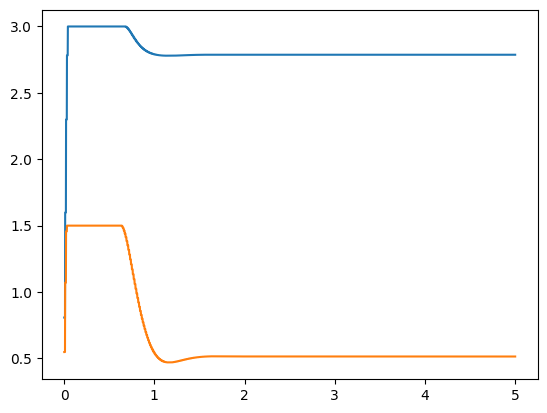

In [37]:
plt.plot(time_opt, opt_controls[:, 0])
plt.plot(time_opt, opt_controls[:, 1])

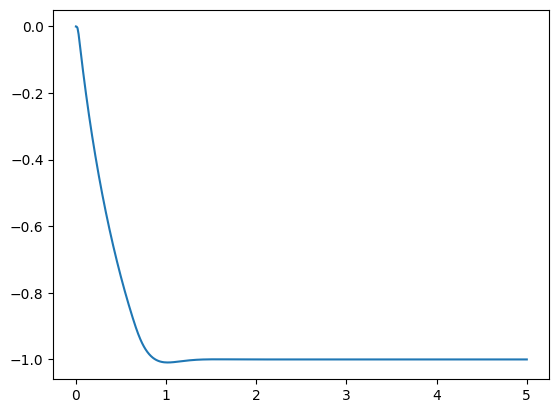

In [38]:
plt.plot(time_opt, opt_traj)

In [62]:
Pd = list(map(lambda df: df["Pd"].to_numpy().reshape(-1, 1), df_list))

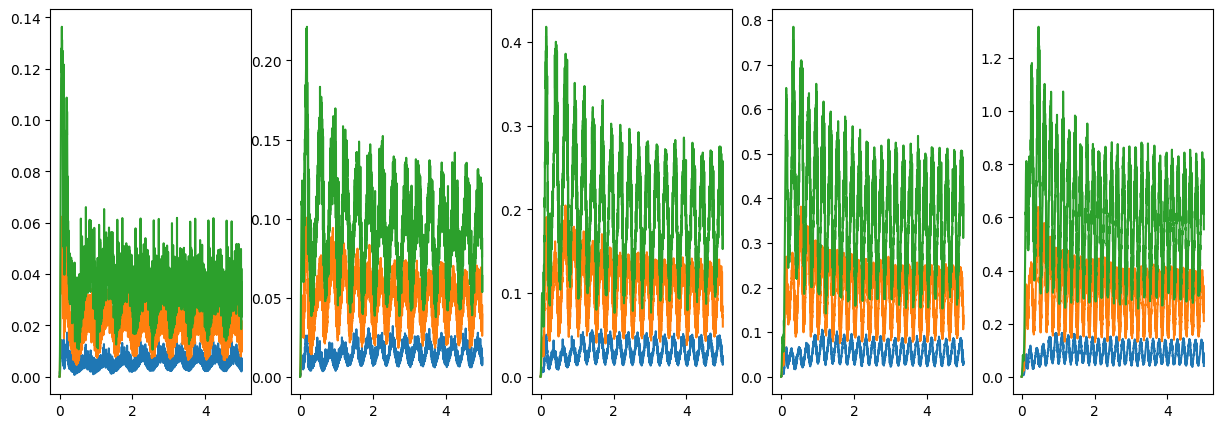

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
counter = 0
for nc,f in enumerate(freqs):
    for a in amps:
        axes[nc].plot(time[counter], Pd[counter])
        counter += 1

In [64]:
Ed = list(map(lambda ed: np.asarray(ed).reshape(-1, 1), ed_list))

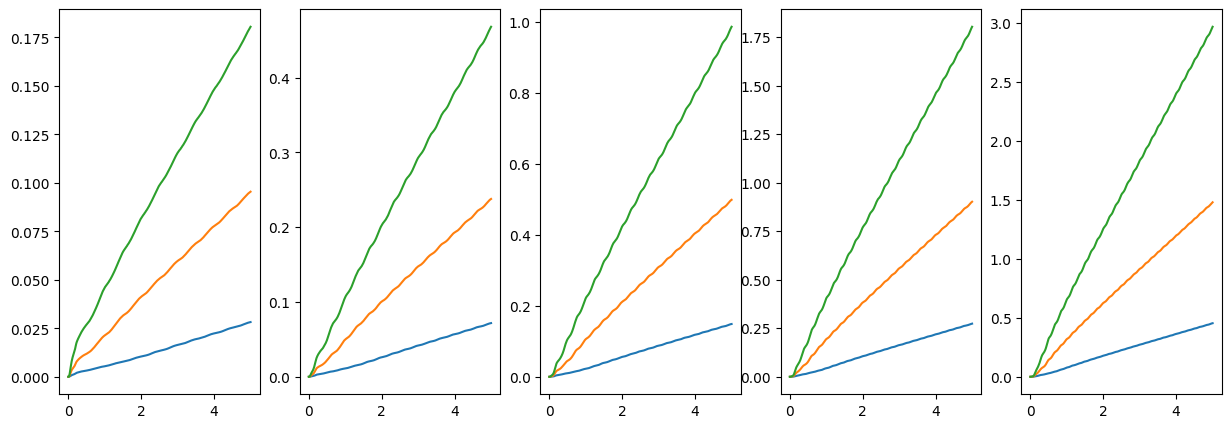

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
counter = 0
for nc,f in enumerate(freqs):
    for a in amps:
        axes[nc].plot(time[counter], Ed[counter])
        counter += 1

In [77]:
def train_e(train_trajectories, train_controls, train_times, threshold, degree=5):
    feature_names = ["ed", "f", "a"]
    
    
    #sindy_lib = ps.PolynomialLibrary(degree=degree, include_interaction=True, include_bias=False)
    
    af_functions = [
        lambda x,y: x*y,
        lambda x,y: x**2*y,
        lambda x,y: x*y**2,
        lambda x,y: x**2*y**2,
        lambda x,y: x**3*y,
        lambda x,y: x*y**3, 
    ]

    af_functions_names = [
        lambda x,y: x+' '+y,
        lambda x,y: x+'^2 '+y,
        lambda x,y: x+' '+y+'^2',
        lambda x,y: x+'^2 '+y+'^2',
        lambda x,y: x+'^3 '+y,
        lambda x,y: x+' '+y+'^3',  
    ]

    af_lib = ps.CustomLibrary(library_functions=af_functions, function_names=af_functions_names)
    
    eaf_functions = [
        lambda x,y,z: x*y*z,
        lambda x,y,z: x**2*y*z,
        lambda x,y,z: x*y**2*z,
        lambda x,y,z: x*y*z**2,
    ]

    eaf_functions_names = [
        lambda x,y,z: x+' '+y+' '+z,
        lambda x,y,z: x+'^2 '+y+' '+z,
        lambda x,y,z: x+' '+y+'^2 '+z,
        lambda x,y,z: x+' '+y+' '+z+'^2',
    ]

    eaf_lib = ps.CustomLibrary(library_functions=eaf_functions, function_names=eaf_functions_names)
    
    inputs_per_library = np.tile([0,1,2], 2).reshape((2,3))
    inputs_per_library[0,0]= 1

    print(inputs_per_library)
    
    sindy_lib = ps.GeneralizedLibrary([af_lib, eaf_lib], inputs_per_library=inputs_per_library)
        
    alpha = 2.0
    #sfd = ps.SINDyDerivative(kind="kalman", alpha=alpha)
    sfd = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 10})
        
    
    opt = ps.STLSQ(threshold=threshold)
    
    model = ps.SINDy(optimizer=opt, differentiation_method=sfd, feature_library=sindy_lib,
                 feature_names=feature_names)
    
    model.fit(train_trajectories, t=train_times, u=train_controls, multiple_trajectories=True)
    
    return model

In [78]:
threshold = 0.012
model_ed = train_e(train_trajectories=Ed, train_controls=controls, 
                 train_times=time, threshold=threshold, degree=4)

[[1 1 2]
 [0 1 2]]


In [79]:
model_ed.get_feature_names()

['f a',
 'f^2 a',
 'f a^2',
 'f^2 a^2',
 'f^3 a',
 'f a^3',
 'ed f a',
 'ed^2 f a',
 'ed f^2 a',
 'ed f a^2']

In [80]:
print(len(model_ed.get_feature_names()))
print(len(model_ed.coefficients().nonzero()[1]))

10
9


In [81]:
model_ed.print()

(ed)' = 0.073 f a + -0.068 f^2 a + -0.050 f a^2 + 0.050 f^2 a^2 + 0.017 f^3 a + 0.031 ed f a + 0.013 ed^2 f a + -0.018 ed f^2 a + -0.018 ed f a^2


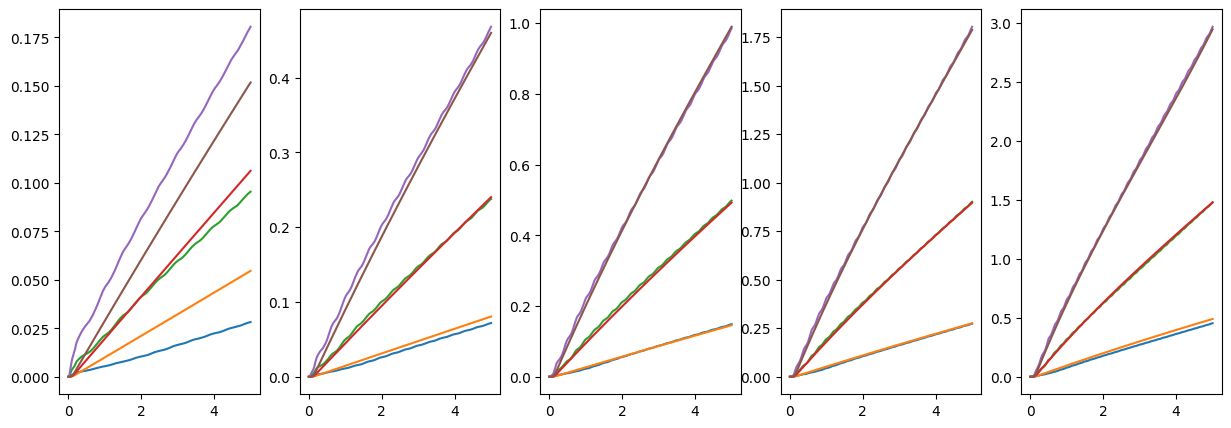

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

counter = 0
for nc,f in enumerate(freqs):
    for a in amps:
        x0_test = [0.0]
        x_test = model_ed.simulate(x0=x0_test, t=time[counter], u=controls[counter])
        axes[nc].plot(time[counter], Ed[counter])
        axes[nc].plot(time[counter][1:], x_test)
        
        counter += 1

In [83]:
d = 3
tau_root = np.append(0, ca.collocation_points(d, 'legendre'))

In [84]:
C = np.zeros((d+1,d+1))
D = np.zeros(d+1)

In [50]:
# Construct polynomial basis
for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
    p = np.poly1d([1])
    for r in range(d+1):
        if r != j:
            p *= np.poly1d([1, -tau_root[r]]) / (tau_root[j]-tau_root[r])

    # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
    D[j] = p(1.0)

    # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
    pder = np.polyder(p)
    for r in range(d+1):
        C[j,r] = pder(tau_root[r])

In [51]:
# Time horizon
T = 12

In [52]:
p = ca.SX.sym("p")
v = ca.SX.sym("v")
e = ca.SX.sym("e")
x = ca.vertcat(p,v,e)
f = ca.SX.sym("f")
a = ca.SX.sym("a")
u = ca.vertcat(f, a)

In [53]:
#(ux)' = -0.209 ux + -0.276 ux^2 + -0.436 ux^3 + -0.067 f a + -0.109 f^2 a^2 + 0.148 ux f a + -0.261 ux^2 f a + -0.071 ux f^2 a + -0.344 ux f a^2
#(ed)' = 0.073 f a + -0.068 f^2 a + -0.050 f a^2 + 0.050 f^2 a^2 + 0.017 f^3 a + 0.031 ed f a + 0.013 ed^2 f a + -0.018 ed f^2 a + -0.018 ed f a^2
#(ed)' = 0.404 a + 0.044 f a + -1.597 a^2 + -0.122 f a^2 + 1.866 a^3 + 0.054 f^2 a^2 + -0.630 a^4



pdot = v
vdot = -0.209*v-0.276*v**2-0.436*v**3-0.067*f*a-0.109*f**2*a**2+0.148*v*f*a-0.261*v**2*f*a-0.071*v*f**2*a-0.344*v*f*a**2
edot = 0.073*f*a-0.068*f**2*a-0.050*f*a**2+0.050*f**2*a**2+0.017*f**3*a+0.031*e*f*a+0.013*e**2*f*a-0.018*e*f**2*a-0.018*e*f*a**2
#edot = 0.404*a+0.044*f*a-1.597*a**2-0.122*f*a**2+1.866*a**3+0.054*f**2*a**2-0.630*a**4
xdot = ca.vertcat(pdot, vdot, edot)

In [54]:
dyn_func = ca.Function('dyn_func', [x, u], [xdot], ["x", "u"], ["xdot"])
obj_func = ca.Function('obj_func', [x], [e], ["x"], ["e"])

In [55]:
N = 60
h = T/N

In [56]:
h

0.2

In [57]:
# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

u_list = []

In [58]:
# For plotting x and u given w
x_plot = []
u_plot = []

In [59]:
# "Lift" initial conditions
Xk = ca.MX.sym('X0', 3)
w.append(Xk)
lbw.append([0, 0, 0])
ubw.append([0, 0, 0])
w0.append([0, 0, 0])
x_plot.append(Xk)

In [60]:
for k in range(N):
    #New NLP variable for the control
    Uk = ca.MX.sym('U_' + str(k), 2)
    u_list.append(Uk)
    
    if k > 0:
        #g.append(Uk[1]-u_list[-2][1])
        #lbg.append([-0.1])
        #ubg.append([0.1])
        g.append(Uk-u_list[-2])
        lbg.append([-0.2, -0.1])
        ubg.append([0.2, 0.1])
    
    w.append(Uk)
    lbw.append([0, 0.5])
    ubw.append([3, 1.5])
    w0.append([1.0, 0.5])
    u_plot.append(Uk)
    
    # State at the collocation points
    Xc =[]
    for j in range(d):
        Xkj = ca.MX.sym('X_'+str(k)+'_'+str(j), 3)
        Xc.append(Xkj)
        w.append(Xkj)
        lbw.append([-np.inf, -np.inf, -np.inf])
        ubw.append([np.inf,  np.inf, np.inf])
        w0.append([0, 0, 0])
    
    Xk_end = D[0]*Xk
    for j in range(1, d+1):
        # Expression for the state derivative at the collocation point
        xp = C[0, j]*Xk
        for r in range(d):
            xp = xp + C[r+1,j]*Xc[r]
        
        fj = dyn_func(Xc[j-1], Uk)
        g.append(h*fj-xp)
        lbg.append([0, 0, 0])
        ubg.append([0, 0, 0])
        
        # Add contribution to the end state
        Xk_end = Xk_end + D[j]*Xc[j-1];
    
    # New NLP variable for state at end of interval
    Xk = ca.MX.sym('X_' + str(k+1), 3)
    w.append(Xk)
    if k == N-1:
        lbw.append([-4, -np.inf, -np.inf])
        ubw.append([-4,  np.inf, np.inf])
        #J = obj_func(Xk)
        J = Xk[2]
    else:
        lbw.append([-np.inf, -np.inf, -np.inf])
        ubw.append([np.inf,  np.inf, np.inf])
    w0.append([0, 0, 0])
    x_plot.append(Xk)
    # Add equality constraint
    g.append(Xk_end-Xk)
    lbg.append([0, 0, 0])
    ubg.append([0, 0, 0])  

In [61]:
# Concatenate vectors
w = ca.vertcat(*w)
g = ca.vertcat(*g)
x_plot = ca.horzcat(*x_plot)
u_plot = ca.horzcat(*u_plot)
w0 = np.concatenate(w0)
lbw = np.concatenate(lbw)
ubw = np.concatenate(ubw)
lbg = np.concatenate(lbg)
ubg = np.concatenate(ubg)

In [62]:
# Create an NLP solver
prob = {'f': J, 'x': w, 'g': g}
solver = ca.nlpsol('solver', 'ipopt', prob)

In [63]:
# Function to get x and u trajectories from w
trajectories = ca.Function('trajectories', [w], [x_plot, u_plot], ['w'], ['x', 'u'])

In [64]:
# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
x_opt, u_opt = trajectories(sol['x'])
x_opt = x_opt.full() # to numpy array
u_opt = u_opt.full() # to numpy array

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3947
Number of nonzeros in inequality constraint Jacobian.:      236
Number of nonzeros in Lagrangian Hessian.............:     1260

Total number of variables............................:      839
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:      720
Total number of inequality constraints...............:      118
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      118
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 3.81e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

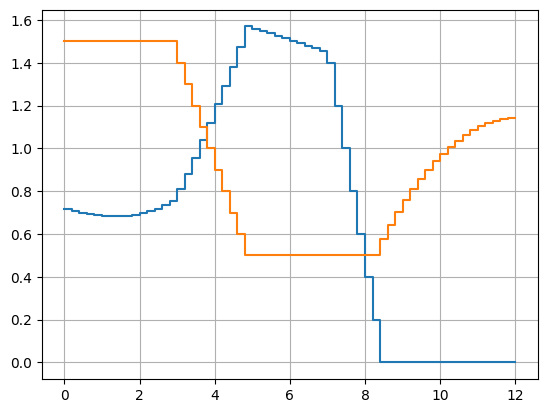

In [65]:
tgrid = np.linspace(0, T, N+1)
plt.figure(1)
plt.clf()
#plt.plot(tgrid, x_opt[0])
#plt.plot(tgrid, x_opt[1])
#plt.plot(tgrid, x_opt[2])

plt.step(tgrid, np.append(np.nan, u_opt[0]))
plt.step(tgrid, np.append(np.nan, u_opt[1]))
#plt.xlabel('t')
#plt.legend(['x1','x2','u'])
plt.grid()
plt.show()

In [14]:
u_opt = np.load("u_opt.npy")
x_opt = np.load("x_opt.npy")

In [15]:
df_test = pd.read_hdf("/scratch/kmaroun/energy_efficiency3/obstacles.hdf5")
with open("/scratch/kmaroun/energy_efficiency3/ed.pkl", "rb") as f:
        ed_test = np.array(pickle.load(f))

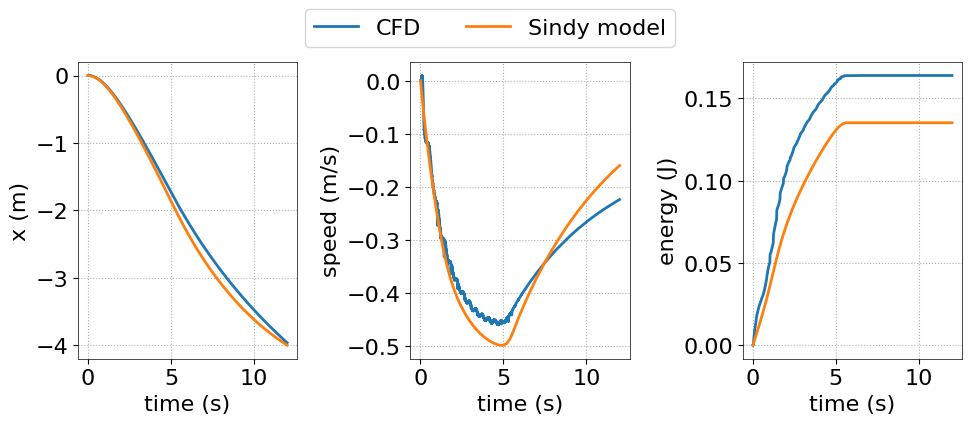

In [29]:
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['savefig.dpi'] = 300

label1 = "CFD"
label2 = "Sindy model"

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

tgrid = np.linspace(0, 12, 61)

ax1.plot(df_test["time"], df_test["x"], label=label1)
ax1.plot(tgrid, x_opt[0], label=label2)
ax1.set_xlabel("time (s)")
ax1.set_ylabel("x (m)")
ax1.grid(True, linestyle="dotted")

ax2.plot(df_test["time"], df_test["Ux"], label=label1)
ax2.plot(tgrid, x_opt[1], label=label2)
ax2.set_xlabel("time (s)")
ax2.set_ylabel("speed (m/s)")
ax2.grid(True, linestyle="dotted")

ax3.plot(df_test["time"], ed_test, label=label1)
ax3.plot(tgrid, x_opt[2], label=label2)
ax3.set_xlabel("time (s)")
ax3.set_ylabel("energy (J)")
ax3.grid(True, linestyle="dotted")

handles, labels = ax2.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(0.7, 1.1), ncol=2)

fig.tight_layout()
#fig.savefig("../model_mismatch.png", bbox_extra_artists=(lgd,), bbox_inches='tight')